In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, show
import matplotlib.gridspec as gridspec

actuals = pd.read_csv(r"all_time_entries_apr_12_21_to_jun_23_21.csv", parse_dates=['Date'])[["Date", "Project", "Task/Deliverable", "Time in Hours"]]
actuals.rename(columns={"Task/Deliverable":"Task","Time in Hours":"Time"}, inplace=True)

scheduled = pd.read_csv(r"scheduled-april-july.csv")

colourKeys = pd.unique(actuals.Project)
colours = dict(zip(colourKeys, plt.cm.tab20.colors[:len(colourKeys)]))

months_in_file = pd.unique(actuals.Date.dt.month_name())
#projects_in_scope = pd.unique(actuals.Project.append(scheduled.Project))

rows = months_in_file.size
columns = 2

def make_autopct(values):
    #print(values)
    def my_autopct(pct):
        #print(pct)
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:.1f}h)'.format(p=pct,v=val)
    return my_autopct

def hat_graph(ax, xlabels, values, group_labels):
    """
    Create a hat graph.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The Axes to plot into.
    xlabels : list of str
        The category names to be displayed on the x-axis.
    values : (M, N) array-like
        The data values.
        Rows are the groups (len(group_labels) == M).
        Columns are the categories (len(xlabels) == N).
    group_labels : list of str
        The group labels displayed in the legend.
    """

    def label_bars(heights, rects):
        """Attach a text label on top of each bar."""
        for height, rect in zip(heights, rects):
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 4),  # 4 points vertical offset.
                        textcoords='offset points',
                        ha='center', va='bottom')

    values = np.asarray(values)
    x = np.arange(values.shape[1])
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=30, ha='right')
    spacing = 0.3  # spacing between hat groups
    width = (1 - spacing) / values.shape[0]
    heights0 = values[0]
    for i, (heights, group_label) in enumerate(zip(values, group_labels)):
        style = {'fill': False} if i == 0 else {'edgecolor': 'black'}
        rects = ax.bar(x - spacing/2 + i * width, heights - heights0,
                       width, bottom=heights0, label=group_label, **style)
        ax.set_ylim([0, np.max(np.ravel(values)) + 5])
        label_bars(heights, rects)

### By Project

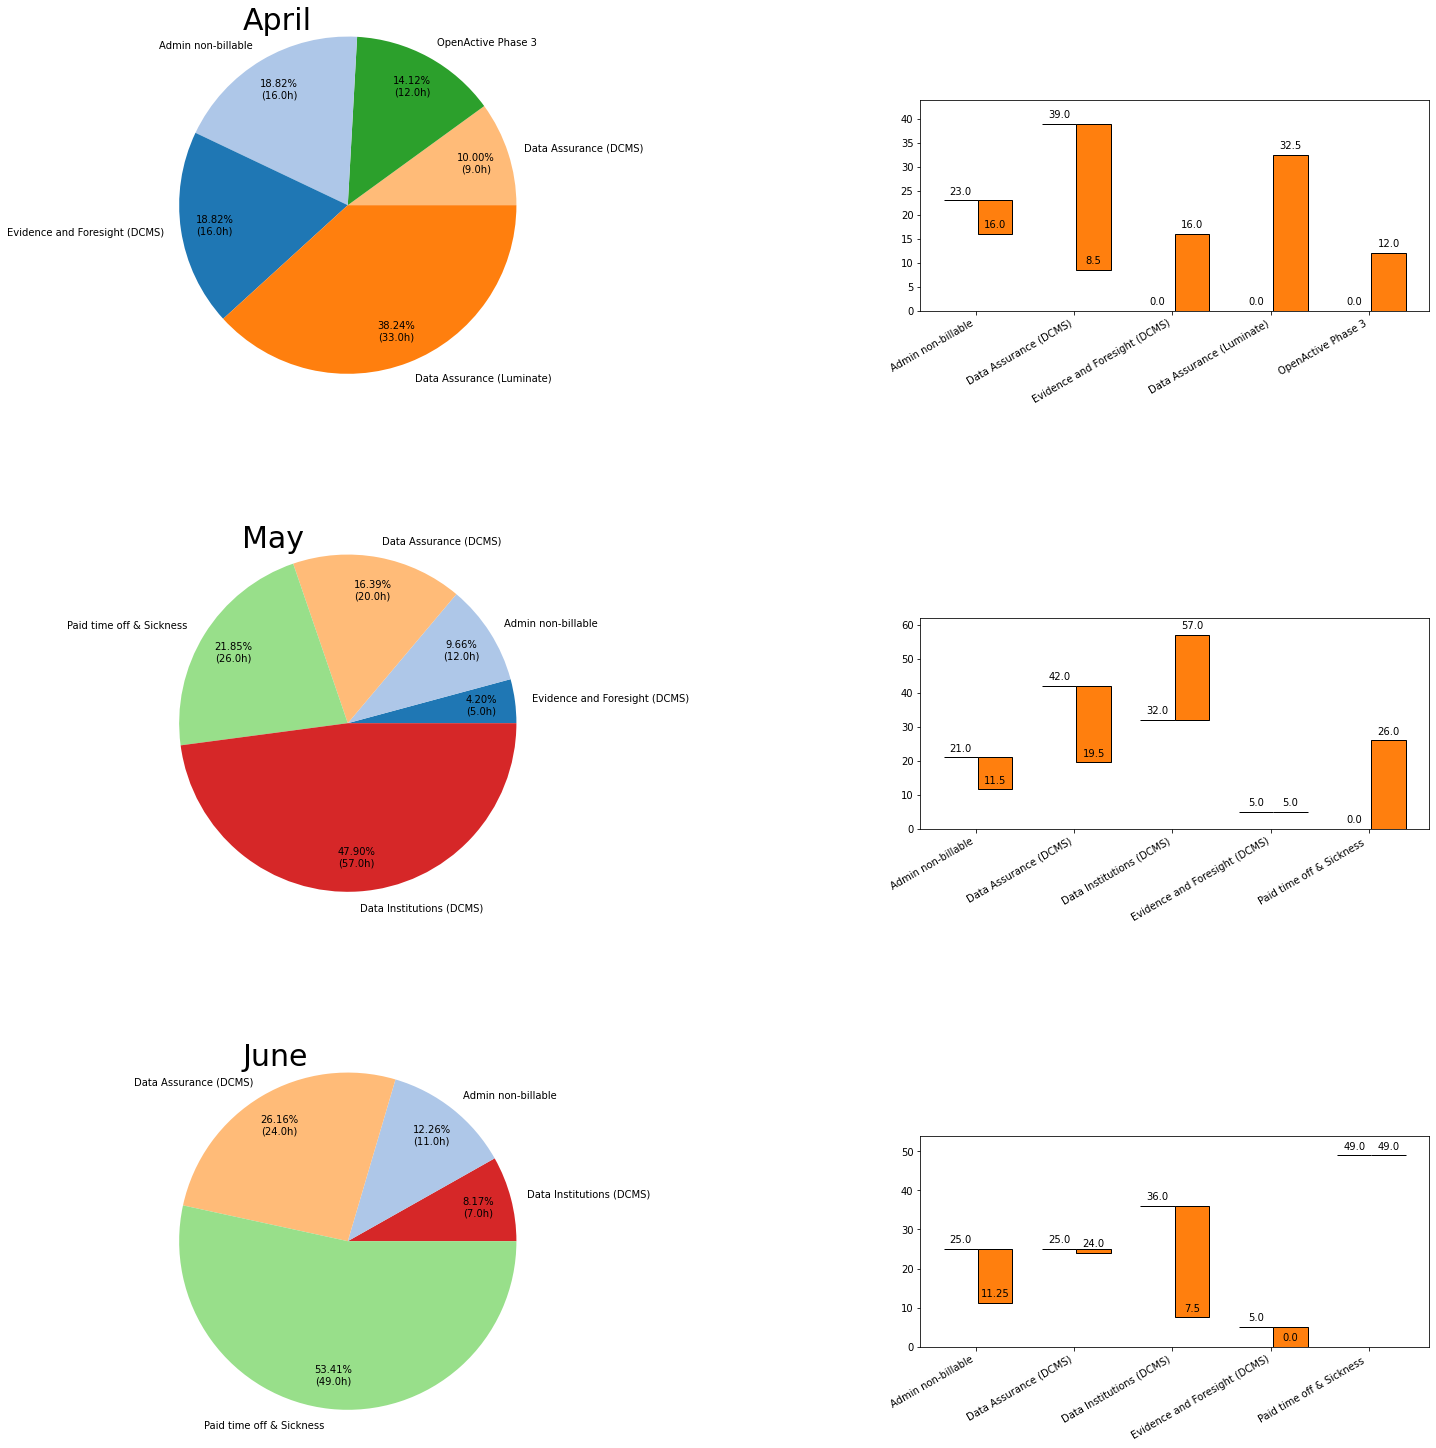

In [8]:
fig = plt.figure(figsize=(20,20), constrained_layout=True)
#ax = fig.add_axes([0,0,1,1])
#ax.axis('equal')
#grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25, figure=fig)
grid = gridspec.GridSpec(rows, columns, wspace = .25, hspace = .25, figure=fig)

exclude_tasks = [""]

grid_count = 0
for month in months_in_file:
    
    #### pie chart ####
    ax = fig.add_subplot(grid[grid_count])
    ax.set_title(label=month, fontsize=30, loc='left', pad=70)
    
    # total up the actuals per project
    monthData = actuals[actuals.Date.dt.month_name() == month]
    sums = monthData.groupby(["Project"])["Time"].sum().reset_index()
    sums.set_index('Project', inplace=True)
    sorted_sums = sums.sort_values(by="Time")
    
    # combine the two reports for comparison
    actuals_w_sched = pd.merge(scheduled[scheduled.Month == month], sums, on = 'Project', how='outer')
    actuals_w_sched['Scheduled hours'] = actuals_w_sched['Scheduled hours'].fillna(0)
    actuals_w_sched['Scheduled %'] = actuals_w_sched['Scheduled %'].fillna(0)
    actuals_w_sched['Time'] = actuals_w_sched['Time'].fillna(0)
    actuals_w_sched['Month'] = actuals_w_sched['Month'].fillna(month)
    actuals_w_sched.sort_values(by='Project')
    actuals_w_sched = actuals_w_sched.query('`Scheduled hours` !=0 | `Scheduled %` != 0 | Time !=0')
    #print(actuals_w_sched)
    
    plt.pie(sorted_sums.Time.values, 
        labels=sorted_sums.index.values, 
        colors=[colours[key] for key in sorted_sums.index],
        autopct=make_autopct(sorted_sums.Time.values),
        radius=2,
        pctdistance=0.8, 
        labeldistance=1.1);
    
    grid_count += 1
    
    #### barchart ####
    ax = fig.add_subplot(grid[grid_count])
    xlabels = actuals_w_sched['Project'].values
    scheduled_vals = actuals_w_sched['Scheduled hours'].values
    actual_vals = actuals_w_sched['Time'].values
    hat_graph(ax, xlabels, [scheduled_vals, actual_vals], ['Scheduled', 'Actual'])

    grid_count += 1
    